# Final Notebook

<b>Title:</b> Hotel Review Analysis Using NLP and Machine Learning

<b>Author:</b> Ismael Araujo


# Business Problem

One of the biggest problems that many companies have been battleling is how to take advantage of all the data that is collected by them. The travel industry has been challenged by the amount of data. One of the types of data is reviews left by guests in websites such as Booking.com, TripAdvisor, and Yelp.

Hotels have been trying to find ways to analyze the reviews and get insights out of it. However, some hotels can receive thousands of guests every week and hundreds of reviews. It becomes nearly impossible and expensive for hotels to keep track of the reviews. Thus, multiple hotels might negligete these valuable data due to the cost and energy that need to be allocated.

For these reasons, here are a few questions that I will try to answer with this project:

- Can machine learning be used to correctly identify positive or negative reviews?
- Can NLP be used to create a useful word cloud with the the positive and negative reviews?
- How is a specific hotel compared to the other hotels in the same city? Can we find more information about the guests based on their review?

## Data and Methods

The dataset for this project was originally used in the study Text Mining in Hotel Reviews: Impact of Words Restriction in Text Classification by Diego Campos, Rodrigo Rocha Silva, and Jorge Bernadino and a team at University of Coimbra. The raw dataset is from Kaggle. The original dataset had 515,738 observations and 17 columns.

<img src="images/feature-columns.png">

## Challenges

The data set was quite organized. However, it had a few challenges. For example, the review was divided between positive and negative reviews. Although this is useful for specific cases, most reviews will not be separated by positive and negative reviews. Thus, creating a model that is able to idenfity positive and negative reviews could be useless if we add reviews that are not separated. Other uses for the model, such as using it in social media would not work. A solution was merging the together.

Other big challenge with dataset is that the address is a long string, which means that is difficult to collect information such as city and country due to the different formats which is written. This problem was solved grabbing the city and country of the hotel using Geopy.

## Data Understanding

Data understanding was a very interesting step in this project. I was able to understand the dataset. First thing I noticed was that the dataset was very large. This could be a problem when modeling. Thus, for the MVP, I decided to use only 20% of the dataset to avoid the curse of dimentionality.

Since I had a classification problem, I first created a target feature with the score. In this step I noticed that the lowest score was 2.5 and the highest was 10. Since there were users who wrote that there was anything good about the hotel, I assume that 2.5 was actually given by Booking.com, not the user. Then I converted the score into a classification problem. Since 2.5 was the lowest and 10 the highest, I decided to dived the target in two: positive and negative, where anything below 6 was negative and 6 and above was positive. 6.25 would be the middle point, so I decided to go with 6.

### Data Cleaning

As in any NLP project, the data cleaning is the most important step. We need to make sense of the information we have and create features for the models only with the information that matters. A few cleaning steps that I took were:

- Remove any puntuations, stop words, and numbers
- Fix the spelling using TextBlob
- Lemmatization
- Remove words from the word clouds that didn't help with insights, such as complimentatory adjectives (great, good, nice, excelent, etc.)

Let's see how it was done.

In [1]:
# Importing Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os

# NLP Packages
import nltk 
from nltk.corpus import stopwords
from textblob import TextBlob 
from textblob import Word
import re
import string
from sklearn.feature_extraction.text import CountVectorizer

# WordCloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Pandas Settings
pd.set_option('display.max_columns', 10000)
pd.set_option('display.max_rows', 100)

# Solve warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Import csv file
df = pd.read_csv('csv/Hotel_Reviews.csv')

The idea in this step is to take a look at the data. A key points that I want to investigate are:
- Shape of the dataset
- If there are null values
- How many unique hotels and if it matches to the value said in the dataset
- The types of data

In [3]:
# DataFrame shape
df.shape

(515738, 17)

Here we can see that the dataset is large. Some models could take way too long to run a train set this size. Thus, in the first part of this project, I will use 20% of the original dataset. Further in the project, I'm planning on testing best model on the entire dataset. Luckily, since the dataset is so large, we can fix any class imbalance here.

In [4]:
# Selecting only the columns that I will use
features = ['Hotel_Name', 'Negative_Review','Positive_Review', 'Reviewer_Score']
df = df[features]

For NLP, I want to see how the model performs having the positive reviews together, since that's the way that most people write reviews.

In [5]:
# Putting reviews together
df['Reviews'] = df['Negative_Review'] + df['Positive_Review']

In [6]:
# Keep only 20% of the dataframe
df = df.sample(frac=0.20, random_state=1)

In [7]:
# Checking the hotel with the highest number of reviews
df.pivot_table(index=['Hotel_Name'], aggfunc='size').nlargest()

Hotel_Name
Britannia International Hotel Canary Wharf           965
Strand Palace Hotel                                  900
Park Plaza Westminster Bridge London                 846
Copthorne Tara Hotel London Kensington               748
DoubleTree by Hilton Hotel London Tower of London    641
dtype: int64

We now have only 20% of the dataset. We can see that Britannia International Hotel Canary Wharf is still the hotel with the most reviews, which shows us that pandas sample function really works as expected. I mentioned this in the <a href="https://github.com/Ismaeltrevi/hotel-reviews-analysis-using-nlp/blob/main/preprossessing/eda.ipynb">EDA</a> notebook.

Now it's time to clean data. The function below lowercase all the words, removes punctuations, and digits.

In the <a href="https://github.com/Ismaeltrevi/hotel-reviews-analysis-using-nlp/blob/main/preprossessing/eda.ipynb">EDA</a> notebook I explain that the lowest score is 2.5, which I believe the users don't have the option to choose the score and it must be automatic. For this reason, there are only scores between 2.5 and 10. For this reason, I choose the half point between these two numbers to create my variable.

In [8]:
# This function lowercase all the review words, removes punctuation and numbers
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)

    return text

round1 = lambda x: clean_text_round1(x)

In [9]:
# Applying clean_text_round1 function
df['Reviews_Clean'] = pd.DataFrame(df.Reviews.apply(round1))

Create a binary classification where anything below 6 is negative review and 6 and above is positive.

In [10]:
# Create function that turns the Reviewer Score into a classification target with 3 values
df['Score'] = df['Reviewer_Score'].apply(lambda x: 0 if x < 6 else 1)

### Class Distribution

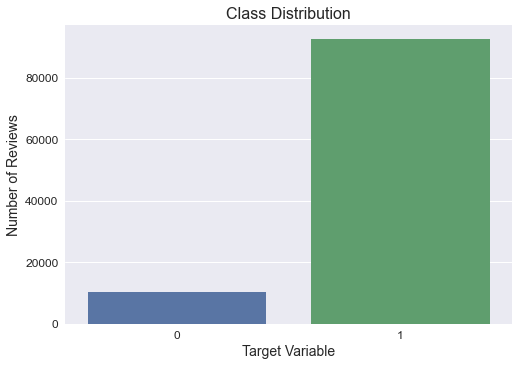

In [11]:
# Checking if the target variable is balanced
plt.style.use('seaborn')
sns.countplot(df['Score'])
plt.title('Class Distribution', fontsize=16)
plt.xlabel('Target Variable', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

We can see that there is a big class imbalance. Since our dataset is large, we can fix this using the pandas sample function. Thus, I will only use 12% of the positive reviews, which will get closer to the number of negative reviews, so it will get closer to the number of negative reviews.

In [12]:
# Creating separate dataframes depending on the classification
df_Score_0 = df[df.Score == 0]
df_Score_1 = df[df.Score == 1].sample(frac=0.12)

In [13]:
# Concatenating th 
df = pd.concat([df_Score_1, df_Score_0])
df.shape

(21620, 7)

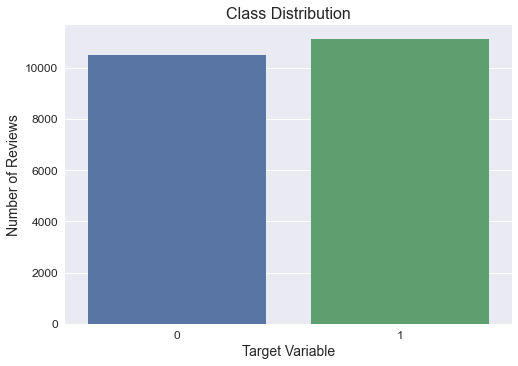

In [14]:
# Checking if the target variable is balanced
sns.countplot(df['Score'])
plt.title('Class Distribution', fontsize=16)
plt.xlabel('Target Variable', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

We can see above that the class distribution problem was solved.

### Spell Checker

Let's fix any spelling mistakes in the review using TextBlob.

In [15]:
# Setting stop words
stop_words = stopwords.words('english')

In [16]:
# Instantiate CountVectorizer
cv = CountVectorizer(stop_words=stop_words)

# Fit and transform dataframe without data cleaning
df_cv = cv.fit_transform(df['Reviews_Clean'])
df_cv = pd.DataFrame(df_cv.toarray(), columns = cv.get_feature_names())
df_cv.index = df.index
df_cv.shape

(21620, 17702)

<b>IMPORTANT NOTE:</b>

The cell below exports the dataset with the spelling checked. If you export it without running the Spell Checker, all the models won't have the target correctly set up. Thus, I don't recommend exporting that cell.

⏳ The cell below takes around 1h 20m to run. Uncomment it to run.

In [17]:
# # Checking if function works
# df['Spell_Checked'] = df['Reviews_Clean'].apply(lambda x: ''.join(TextBlob(x).correct()))

# 1h 21m to run

In [18]:
# Importing the dataset with the spelling checked
df = pd.read_csv('csv/Hotel_Review_Spell_Checked.csv', index_col=0)

In [19]:
# Fit and transform dataframe without data cleaning
df_cv = cv.fit_transform(df['Spell_Checked'])
df_cv = pd.DataFrame(df_cv.toarray(), columns = cv.get_feature_names())
df_cv.index = df.index
df_cv.shape

(21619, 11930)

Done! We reduced our dataset from 17,836 words to 11,930 words. WOW!

### Exploratory Data Analysis

<b>IMPORTANT NOTE:</b> EDA and visualizations use multiple lines of code. To keep this notebook clean, I will only add the images here. All of the following images are in the EDA notebook. 
<b>If you are interested in checking the process, please check the <a href="https://github.com/Ismaeltrevi/hotel-reviews-analysis-using-nlp/blob/main/preprossessing/eda.ipynb">EDA notebook clicking here</a></b>.

Now, let's go back to the EDA.

I wanted a few answer from the dataset and check if I could find any patterns. Thus, I had questions, which I will answer right next:

#### What nationalities give the highest number of reviews?

<img src="images/nationality.png">

Reviewers from the United Kingdom have the highest number of reviews left. To understand the main reason behind this, I checked where the hotels with the highest reviews are located. In the next image we can understand two things:

- The hotels are located in only 6 countries only, not the whole Europe, as I previously thought.
- The reviewers are mostly from the UK (over 50%), which explain the higher number of people from the UK giving reviews.

<img src="images/countries-hotels.png">

#### How does the hotel which I will focus on perform compared to other hotels in London?

<img src="images/score-density-hotel-vs-london.png">

As we can see above, the Britannia International Hotel Canary Wharf underperform compared to other hotels in London. While the hotels in London have the score density skewed to the right where the positive scores are, Britannia International Hotel Canary Wharf is closer to a evenly distribution, where the amount of negative reviews are as high as the negative reviews. This tells as the the hotel has a lot to improve.

For the results section, I had two question in mind:

- What words appear the most in positive and negative reviews?
- Can we get any insights from it?

To get these answers, I had to clean the data through different steps. You can see more details of each step in the Data Cleaning notebook. Now let's check the word clouds and see if we can get insights from it.

Below we can see the positive reviews word cloud. Note that you can relate every word to things that you could image coming from a hotel review. For example, we can see the words location, clean, comfortable, staff, service, price, and room. We can certainly assure that these are high points to the hotel and they can use these words to promote the hotel.

<img src="images/positive_wordcloud.png">

On the other hand, looking at the negative reviews word cloud, we can see many words that could be points for improvement to the hotel. Staff seems it’s mentioned multiple times as well as the word rude and reception. Maybe the staff was rude to these guests? We can also see the words old, dated, dirty, and uncomfortable, which could be points of attention to the management.

<img src="images/negative_wordcloud.png">

If you are interested in more EDA, please take a look at the <a href="https://github.com/Ismaeltrevi/hotel-reviews-analysis-using-nlp/blob/main/preprossessing/eda.ipynb">EDA</a> notebook.

## Modeling

For the modeling process, I chose multiple models, testing them with different vectorizer and in different stages of data cleaning. For the baseline models, I ran Logistic Regression, Random Forest, Naive Bayes, and Support Vector Machine.

I tried the vanilla models with the datasets vectorized with CountVectorizer, TF-IDF. I also tried these models with and without lemmatization. I did not include other features such as name of the hotel or location because the main objective is train a model using the reviews only. In the following  cells will run the best model, which was a SVC using the TF-IDF vectorizer. SVC is known for working well with NLP. Thus, there is no surprise that it outperformed other models.

The best performing model was a GridSearch CVS using TF-IDF vectorizer. I did the following process.

### Preprocessing

In [20]:
# Sklearn Packages
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils import resample
from sklearn.ensemble import BaggingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from IPython.core.display import display, HTML

# Import pickle
import pickle

In [21]:
# Creating an X variable and y for my target
X = df.Spell_Checked
y = df.Score

#### Train Test Split

As mentioned in the introduction, I will use the column `Spell_Checked` to create the features and `Score` as my target.

In [22]:
# Splitting the dataset in train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [23]:
# Instantiate TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words=stop_words)

# Fitting into the train and test set
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

### Evaluation Metric

The evaluation metric below will simplify the model evaluation. My main focus is the accuracy metric. Have an accurate is important to be accurate. However, although fixing False Negatives is not crucial, I will also take a look at Recall and F1-Score to understand how my model is working. Since it is not my main focus, I will not mentioned in the individual analysis on my models.

In [24]:
# %load functions/evaluation.py
# Evaluation function

def evaluation(y_true, y_pred):

    print('Evaluation Metrics:')
    print('Accuracy: ' + str(metrics.accuracy_score(y_true, y_pred)))
    print('Precision: ' + str(metrics.precision_score(y_true, y_pred)))
    print('Recall: ' + str(metrics.recall_score(y_true, y_pred)))
    print('F1 Score: ' + str(metrics.f1_score(y_true, y_pred)))

In [25]:
# Importing best model
grid_svc = pickle.load(open('pickle/final_model.pickle','rb'))

In [26]:
final_model = grid_svc.predict(X_test)

In [27]:
# Evaluating model
evaluation(y_test, final_model)

Evaluation Metrics:
Accuracy: 0.8222016651248844
Precision: 0.8622047244094488
Recall: 0.7818636201356658
F1 Score: 0.8200711477251451


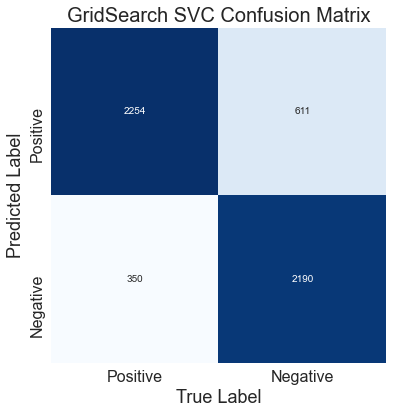

In [28]:
# Plotting a confusion matrix
plt.figure(figsize=(6, 7))
mat = confusion_matrix(y_test, final_model)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'], cmap="Blues")
plt.xlabel('True Label', fontsize= 18)
plt.ylabel('Predicted Label', fontsize= 18)
plt.title('GridSearch SVC Confusion Matrix', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
b, t = plt.ylim()  
plt.ylim(b, t)
plt.show()

GridSearch SVC was able to predict correctly 85.13% of the positive reviews and 72.79%. My stretch how is going to be improve this model and test it in reviews from other websites and social media.

Since this model was tested with positive and negative reviews, it should be able to grab reviews from other websites and predict as well.

# Next Steps:

- Test the model in the whole data set
- Use the features of the model with the highest coeficcient to understand which words can predict better if a review is good or not and test
- Use the features with the highest coeficcient to predict if posts in social media are positive or negative
- Create a recommendation system to the user based on reviews

## Create a function for Sentiment Analysis

In this step, I will generate a sentiment analysis. Normally, this would be a step that I'd run after data cleaning for NLP. However, previous tests showed me that data cleaning does not affect the sentiment analysis using TextBlob.

Running sentiment analysis takes a lot of time because I have more than 515K observations. For this reason, once the sentiment analysis is created, I will pickle the DataFrame and upload it again, so it won't run again.

In [29]:
# Create a function to get subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Create a function to get polarity with tweets
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

<b>NOTE:</b>

Each of the two following cells takes around 10 minutes to run. For this reason, I will sabe the DataFrame into a csv file and upload it again.

In [30]:
# Create new columns to compare polarity and subjetivity on Negative Reviews
df['Polarity_Net'] = df['Negative_Review'].apply(getPolarity)
df['Polarity_Pos'] = df['Positive_Review'].apply(getPolarity)

In [31]:
# Saving csv with sentiment analysis
df.to_csv("csv/df_sentiment_analysis.csv")

In [32]:
# Importing DataFrame with new Polarity column
df = pd.read_csv('csv/df_sentiment_analysis.csv', index_col=0)

In [33]:
# Checking columns
df.columns

Index(['Unnamed: 0.1', 'Hotel_Name', 'Negative_Review', 'Positive_Review',
       'Reviewer_Score', 'Reviews_Clean', 'Score', 'Spell_Checked',
       'Polarity_Net', 'Polarity_Pos'],
      dtype='object')

In [34]:
# Creating function to classify the Sentiment Analysis
df['Sent_Analysis_Neg'] = df['Polarity_Net'].apply(lambda x: 0 if x < 0 else 1 if x > -0.1 and x < 0.1 else 2)
df['Sent_Analysis_Pos'] = df['Polarity_Pos'].apply(lambda x: 0 if x < 0 else 1 if x > -0.1 and x < 0.1 else 2)

In [35]:
# Creating a csv file with the sentiment analysis
sentiment_analysis = df[['Hotel_Name','Negative_Review','Positive_Review','Reviewer_Score','Sent_Analysis_Neg','Sent_Analysis_Pos']]

# Uncomment cell below to export file
# sentiment_analysis.to_csv('sentiment_analysis.csv')

### Findings and Takeaways:

- It was created Subjectivity and Polarity features using sentiment analysis for Negative and Positive Reviews. 
- Polarity ranges between -1 and 1. Where -1 means that the review was very negative and 1 means that the review was very positive.
- Seems like sentiment analysis does a good job identifying positive reviews, but the negative reviews could be improved.

## Final Recommendations
- Use machine learning models to quickly identify negative and positive reviews without having to read all of them.
- Use word clouds to get quick insights from negative and positive reviews. The negative reviews can be used to improve the business and positive reviews can be used for advertisement, for example.

## Conclusion

- Machine learning can be used to correctly identify positive and negative reviews. However, identify with 100% confidence would be extremely difficult.
- Word clouds can be used to understand what words appear the most in negative and positive reviews. The management can quickly take a look and get insights out of it.
- The Britannia International Hotel Canary Wharf performes poorly in the reviews compared to other hotels in London. There is a lot of room for improvement.

## Next Steps:

- Test the model in the whole data set
- Use the features of the model with the highest coeficcient to understand which words can predict better if a review is good or not and test
- Use the features with the highest coeficcient to predict if posts in social media are positive or negative
- Create a recommendation system to the user based on reviews
- Create a dashboard for guests and hotels easily get information about hotels.

## Repository Content

## For More Information or Suggestions
If you have any questions or suggestions, please reach me out.

Email: alves.trevi@gmail.com